In [1]:
from signal_utils import *

## Test Signal

Fmax = 0.425


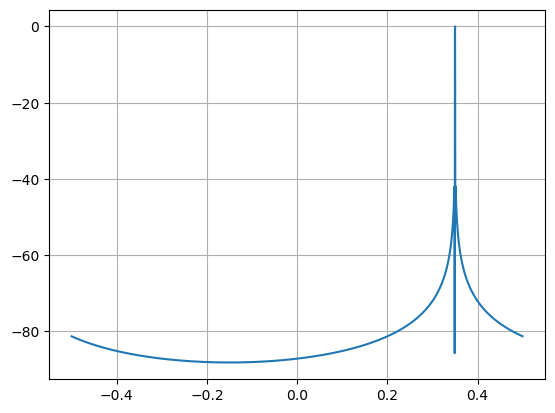

In [2]:
N = 2**12
n = np.arange(N)

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

F = 0.35

x = 1.0 * np.exp(1j * 2*np.pi*F*n)
xr = x.real
xi = x.imag

plotdB(x, True)

## Interpolation

In [3]:
AdB_interpolation = 80
deltaPass = 10**(-AdB_interpolation/20)
deltaStop = deltaPass

OSR = 8
F = [Fmax, 1-Fmax]
delta = [deltaPass, deltaStop]

# Interpolation by a factor of 8
xr_osr8 = np.real(interpolate(xr, OSR, F, delta, show=False, prt=False))
xi_osr8 = np.real(interpolate(xi, OSR, F, delta, show=False, prt=False))
x_osr8 = xr_osr8 + 1j*xi_osr8

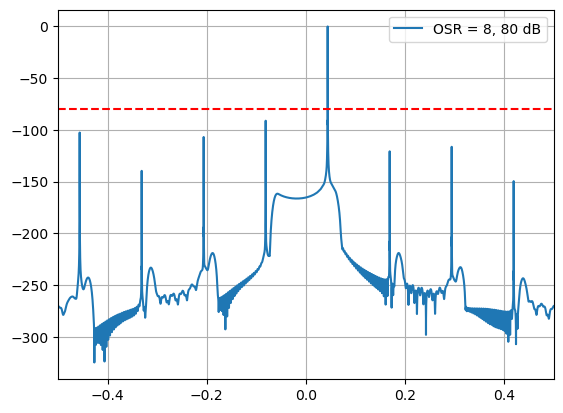

In [4]:
freqs_osr8, xfftdB_osr8, angle_osr8 = fftdB(x_osr8)
xmin = -0.5
xmax = 0.5
plt.plot(freqs_osr8, xfftdB_osr8, label=f"OSR = {OSR}, {AdB_interpolation} dB")
plt.plot([xmin, xmax], [-AdB_interpolation, -AdB_interpolation], '--r')
plt.legend()
plt.xlim([xmin, xmax])
plt.grid()
plt.show();

## Delay Filter

In [5]:
# AdB_delay = 8
# deltaPass = 10**(-AdB_delay/20)
# deltaStop = deltaPass

# I = 4*32
# Fpass = Fmax / I
# Fstop = (1 - Fmax) / I

In [6]:
# firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N*32000, Nmax=N*32000)
# polyFirCoeff = makePolyphase(firCoeff, I)
# commonDelay = int((len(firCoeff) - 1) / I / 2)

# xr_delay = signal.lfilter(polyFirCoeff[-2], 1.0, xr_osr8)
# xi_delay = signal.lfilter(polyFirCoeff[-1], 1.0, xi_osr8)
# x_delay = xr_delay + 1j*xi_delay

# freqs, xfft, angle = fftdB(x_delay)
# plt.plot(freqs, xfft)
# plt.grid()
# plt.show();

In [7]:
# print(len(firCoeff))

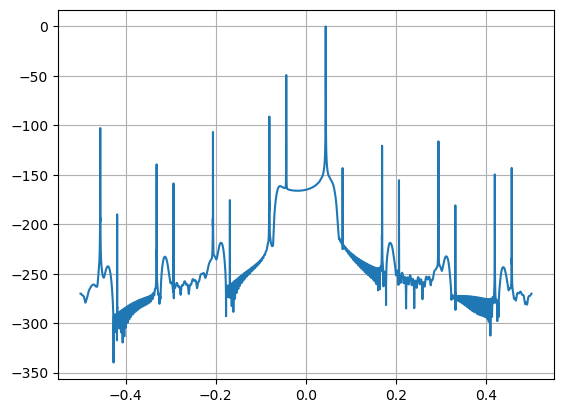

In [8]:
delta_r = 1/2/32
delta_i = 1/4/32
xr_delay = firrow_filter(xr_osr8, delta_r)
xi_delay = firrow_filter(xi_osr8, delta_i)
x_delay = xr_delay + 1j*xi_delay

freqs, xfft, angle = fftdB(x_delay)
plt.plot(freqs, xfft)
plt.grid()
plt.show();

## Delta-Sigma Modulation (from cpp)

In [9]:
quant_type = "mid-tread"

# Path to C++ executable
cpp_path = "../build/delta-sigma"
xr_in_path = "./data/serial/xr_in.txt"
xi_in_path = "./data/serial/xi_in.txt"
xr_out_path = "./data/serial/xr_out.txt"
xi_out_path = "./data/serial/xi_out.txt"
iir_path = "../data/input/deltaSigma_iirs.txt"

In [10]:
quant_type = ["mid-tread", "mid-rise"]
xr_in = xr_osr8
xi_in = xi_osr8

In [11]:
xr_deltaSigma = []
xi_deltaSigma = []
x_deltaSigma = []

for quant_type_i in quant_type:
    tmp = 4/np.max(xr_in)
    xr_input = np.array(xr_in) * tmp
    xi_input = np.array(xi_in) * tmp
    
    np.savetxt(xr_in_path, xr_input, fmt="%.18e")
    np.savetxt(xi_in_path, xi_input, fmt="%.18e")
    
    # Call the C++ program with input and output file paths as arguments
    subprocess.run([cpp_path, xr_in_path, xi_in_path, xr_out_path, xi_out_path, iir_path, quant_type_i])
    
    xr_deltaSigma_tmp = np.round(np.loadtxt(xr_out_path))
    xi_deltaSigma_tmp = np.round(np.loadtxt(xi_out_path))
    x_deltaSigma_tmp = xr_deltaSigma_tmp + 1j*xi_deltaSigma_tmp

    xr_deltaSigma.append(xr_deltaSigma_tmp)
    xi_deltaSigma.append(xi_deltaSigma_tmp)
    x_deltaSigma.append(x_deltaSigma_tmp)

File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt


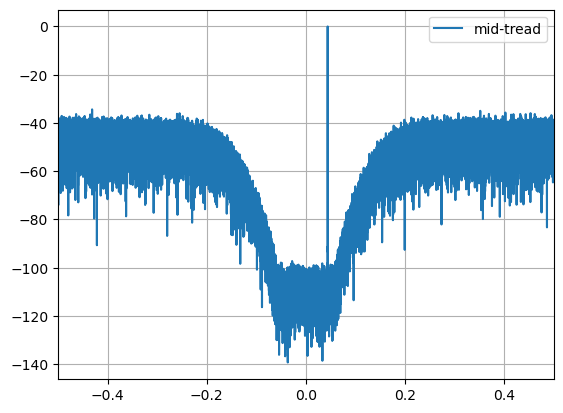

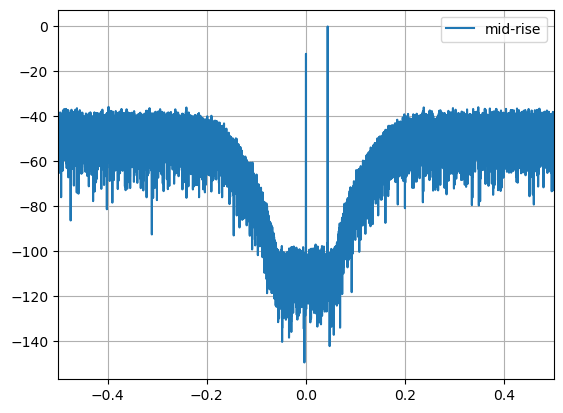

In [12]:
labels=quant_type

for x_i,label_i in zip(x_deltaSigma, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    xmin = -0.5
    xmax = 0.5
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.grid()
    plt.show();

## Serialization (LUT)

In [14]:
LUTs = [LUT1, LUT2, LUT3, LUT4, LUT5]
quant_type = ["mid-tread", "mid-tread", "mid-tread", "mid-rise", "mid-rise"]

xr_serial = []
xi_serial = []
x_serial = []

for LUT, quant_type_i in zip(LUTs, quant_type):
    if quant_type_i == "mid-tread":
        xr_input = xr_deltaSigma[0]
        xi_input = xi_deltaSigma[0]
    else:
        xr_input = xr_deltaSigma[1]
        xi_input = xi_deltaSigma[1]
        
    xr_1b = convert_1b(xr_input, LUT, quant_type_i)
    xi_1b = convert_1b(xi_input, LUT, quant_type_i)
    x_1b = xr_1b + 1j*xi_1b

    xr_serial.append(xr_1b)
    xi_serial.append(xi_1b)
    x_serial.append(x_1b)

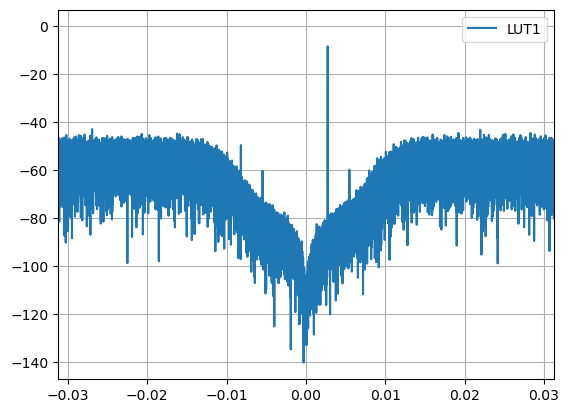

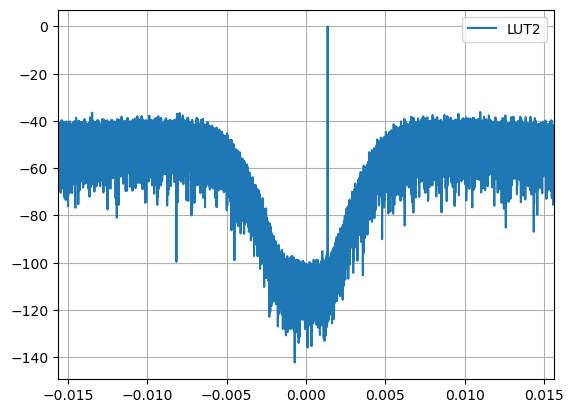

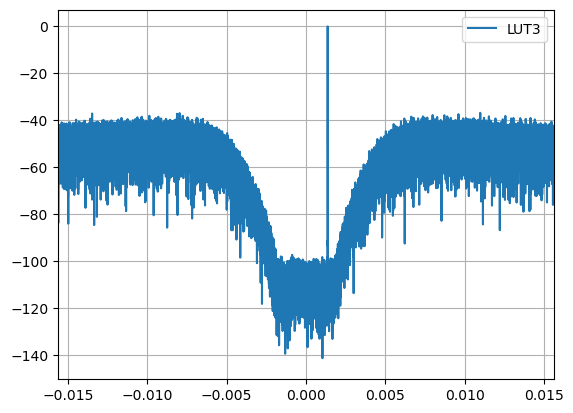

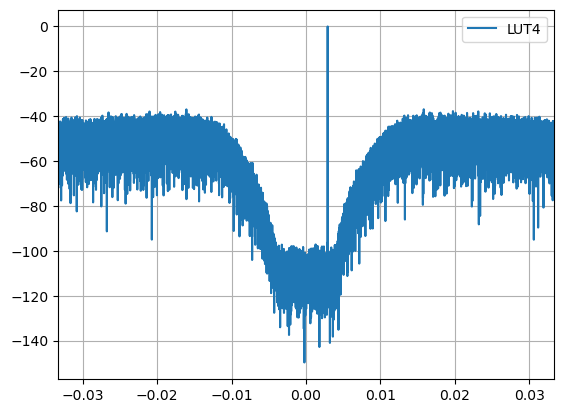

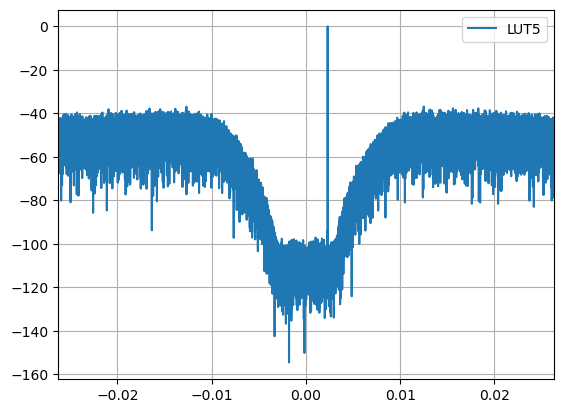

In [15]:
labels = ["LUT1", "LUT2", "LUT3", "LUT4", "LUT5"]

for x_i,LUT,label_i in zip(x_serial, LUTs, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    xmin = -0.5/len(LUT[0])
    xmax = 0.5/len(LUT[0])
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.grid()
    plt.show();

## RFIQ Serial

In [16]:
x_rfiq = []
for xrfiq_in in x_serial:
    x_rfiq.append(rfiq(xrfiq_in.real, xrfiq_in.imag))

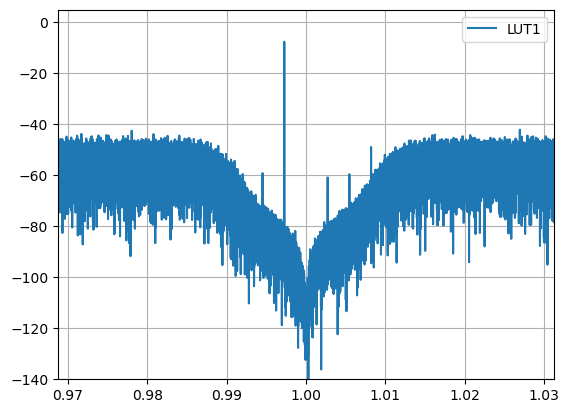

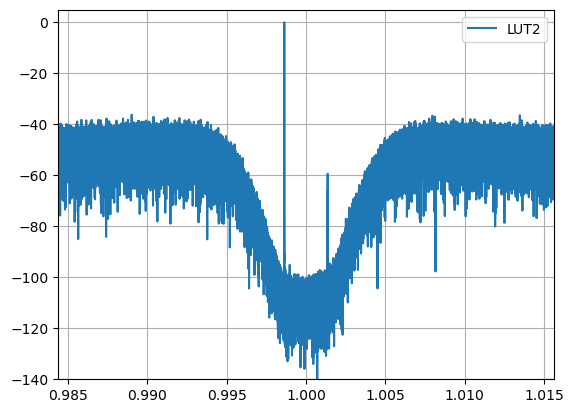

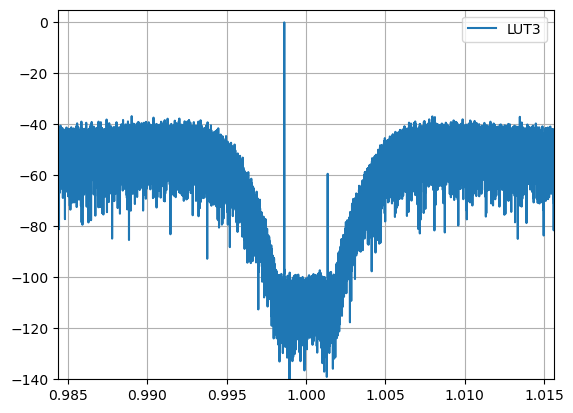

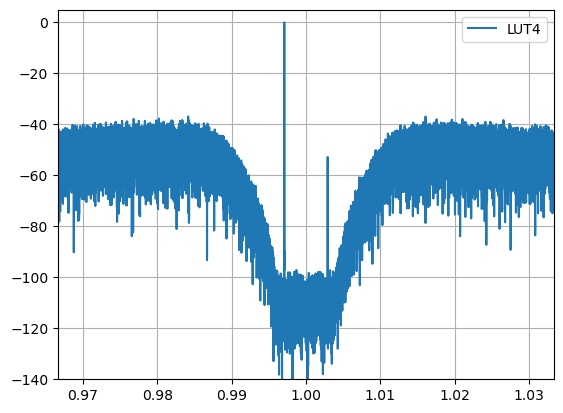

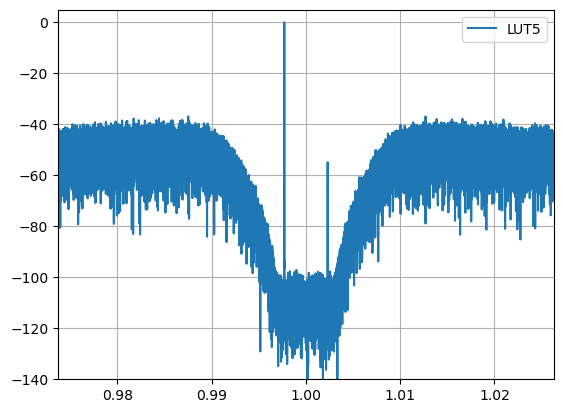

In [17]:
labels = ["LUT1", "LUT2", "LUT3", "LUT4", "LUT5"]

for x_i,LUT,label_i in zip(x_rfiq, LUTs, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    freqs_i *= 4
    xmin = 1-0.5/len(LUT[0])
    xmax = 1+0.5/len(LUT[0])
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.ylim([-140, 5])
    plt.grid()
    plt.show();